## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 243 kB 47.6 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [41]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [42]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [43]:
tweets, labels = get_tweets(train)

In [44]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [46]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


In [13]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

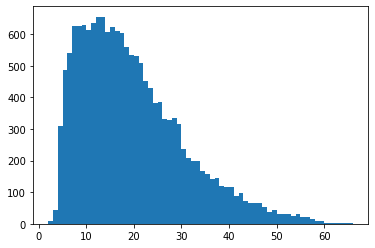

In [47]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [16]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=maxlen, padding='post')
    return padded_sequences

In [49]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [50]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [51]:
classes = set(labels)
print(classes)

{'sadness', 'love', 'surprise', 'joy', 'anger', 'fear'}


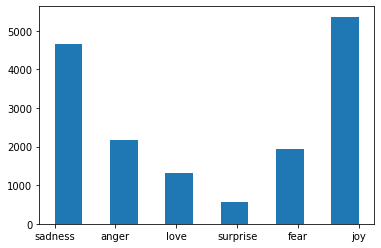

In [52]:
plt.hist(labels, bins=11)
plt.show()

In [53]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [54]:
classes_to_index

{'anger': 4, 'fear': 5, 'joy': 3, 'love': 1, 'sadness': 0, 'surprise': 2}

In [55]:
index_to_classes

{0: 'sadness', 1: 'love', 2: 'surprise', 3: 'joy', 4: 'anger', 5: 'fear'}

In [56]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [57]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [58]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [61]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [62]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [63]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 33s 56ms/step - loss: 1.3338 - accuracy: 0.4519 - val_loss: 0.8027 - val_accuracy: 0.6920
Epoch 2/20
500/500 [==============================] - 26s 53ms/step - loss: 0.5396 - accuracy: 0.8094 - val_loss: 0.4872 - val_accuracy: 0.8410
Epoch 3/20
500/500 [==============================] - 26s 53ms/step - loss: 0.2874 - accuracy: 0.9104 - val_loss: 0.4215 - val_accuracy: 0.8700
Epoch 4/20
500/500 [==============================] - 26s 53ms/step - loss: 0.1877 - accuracy: 0.9406 - val_loss: 0.3981 - val_accuracy: 0.8760
Epoch 5/20
500/500 [==============================] - 26s 53ms/step - loss: 0.1423 - accuracy: 0.9529 - val_loss: 0.3832 - val_accuracy: 0.8775
Epoch 6/20
500/500 [==============================] - 26s 53ms/step - loss: 0.1084 - accuracy: 0.9667 - val_loss: 0.3937 - val_accuracy: 0.8895
Epoch 7/20
500/500 [==============================] - 26s 53ms/step - loss: 0.0852 - accuracy: 0.9731 - val_loss: 0.4313 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

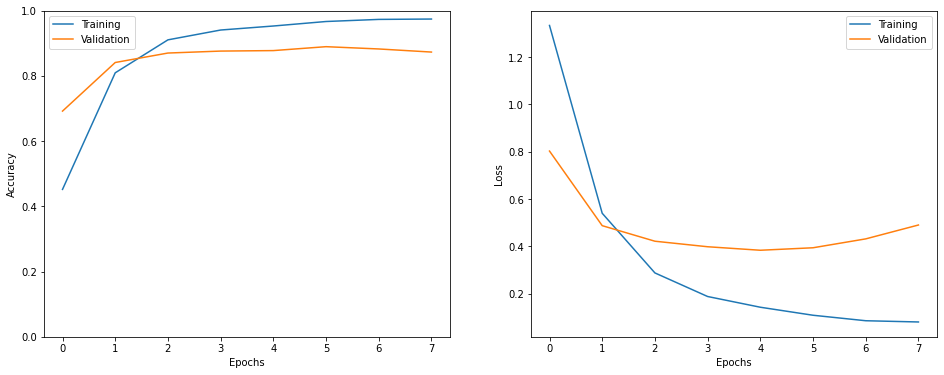

In [64]:
show_history(h)

In [65]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [66]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 18ms/step - loss: 0.5575 - accuracy: 0.8495


In [70]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i feel love se inscrie intr un rafinament lejer romantic si extrem de feminin
Emotion: love


TypeError: ignored

In [71]:
preds = model.predict(test_sequences)
preds.shape, test_labels.shape

((2000, 6), (2000,))

In [72]:
show_confusion_matrix(test_labels, preds, list(classes))

ValueError: ignored